<a href="https://colab.research.google.com/github/skyguavas/Neural-ODEs-for-MNIST/blob/main/CS376_HW2_ODEnet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installer
!pip install torchdiffeq

In [ ]:
# experiment with architecture, batch norm, optimisers, solvers (T or F), dropout after FC, learning rate scheduling etc.

In [ ]:
# imports
import os
import argparse
import logging
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
# parser and conditional import of ode
parser = argparse.ArgumentParser()
parser.add_argument('--network', type=str, choices=['resnet', 'odenet'], default='odenet')
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=True, choices=[True, False])
parser.add_argument('--downsampling-method', type=str, default='res', choices=['conv', 'res'])
parser.add_argument('--nepochs', type=int, default=100)
parser.add_argument('--data_aug', type=eval, default=True, choices=[True, False])
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--test_batch_size', type=int, default=1000)

parser.add_argument('--save', type=str, default='./experiment1')
parser.add_argument('--debug', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
args = parser.parse_args(args=[]) # modified to make it runnable

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

## Set Adjoint as True
## And the solver as Euler

In [ ]:
# model structure
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)


class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x

        out = self.relu(self.norm1(x))

        if self.downsample is not None:
            shortcut = self.downsample(out)

        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)

        return out + shortcut


class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.1) # light dropout
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.conv3 = ConcatConv2d(dim, dim, 3, 1, 1) # another layer
        self.norm4 = norm(dim)
        self.conv4 = ConcatConv2d(dim, dim, 3, 1, 1) # another layer (2)
        self.norm5 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.dropout1(out) # dropout
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        out = self.relu(out)
        out = self.conv3(t, out) # the layer
        out = self.norm4(out)
        out = self.conv4(t, out) # the layer (2)
        out = self.norm5(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=args.tol, atol=args.tol, method='euler')
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [ ]:
# model structure
def get_cifar_loaders(data_aug=True, batch_size=128, test_batch_size=1000, perc=1.0):
    if data_aug:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4), # 32 instead of 28 for larger images
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30), # additional transforms
            transforms.ColorJitter(brightness=0.25, contrast=1, saturation=0.25, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # to normalize
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # to normalize
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # to normalize
    ])

    train_loader = DataLoader(
        datasets.CIFAR10(root='.data/cifar10', train=True, download=True, transform=transform_train), batch_size=batch_size,
        shuffle=True, num_workers=2, drop_last=True
    )

    train_eval_loader = DataLoader(
        datasets.CIFAR10(root='.data/cifar10', train=True, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10(root='.data/cifar10', train=False, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    return train_loader, test_loader, train_eval_loader


def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


def learning_rate_with_decay(batch_size, batch_denom, batches_per_epoch, boundary_epochs, decay_rates):
    initial_learning_rate = args.lr * batch_size / batch_denom

    boundaries = [int(batches_per_epoch * epoch) for epoch in boundary_epochs]
    vals = [initial_learning_rate * decay for decay in decay_rates]

    def learning_rate_fn(itr):
        lt = [itr < b for b in boundaries] + [True]
        i = np.argmax(lt)
        return vals[i]

    return learning_rate_fn


def one_hot(x, K):
    return np.array(x[:, None] == np.arange(K)[None, :], dtype=int)


def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        x = x.to(device)
        y = one_hot(np.array(y.numpy()), 10)

        target_class = np.argmax(y, axis=1)
        predicted_class = np.argmax(model(x).cpu().detach().numpy(), axis=1)
        total_correct += np.sum(predicted_class == target_class)
    return total_correct / len(dataset_loader.dataset)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


def get_logger(logpath, filepath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger(name='logger')
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
    # logger.info(filepath)
    # might not be necessary to read this file since it is raising errors anyway
    # with open(filepath, "r") as f:
        # logger.info(f.read())

    # for f in package_files:
        # logger.info(f)
        # with open(f, "r") as package_f:
            # logger.info(package_f.read())

    return logger

In [ ]:
import datetime

datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

'20240604_101615'

In [ ]:
# This is the main function used to run the entire colab notebook
if __name__ == '__main__':

    import datetime
    now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    makedirs(args.save)
    makedirs(args.save + '/' + now)

    logger = get_logger(logpath=os.path.join(args.save, now + '/logs'), filepath=os.path.abspath('')) # mod to adjust for ipynb
    logger.propagate = False
    logger.info(args)

    device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

    # In order to plot the graphs, the data needs to be stored
    epochs = []
    train_accs = []
    test_accs = []
    epoch_times = []

    is_odenet = args.network == 'odenet'

    if args.downsampling_method == 'conv':
        downsampling_layers = [
            nn.Conv2d(3, 64, 3, 1, padding=1), # stride = 1
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        ]
    elif args.downsampling_method == 'res':
        downsampling_layers = [
            nn.Conv2d(3, 64, 3, 1),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ]

    feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
    fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]

    model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

    logger.info(model)
    logger.info('Number of parameters: {}'.format(count_parameters(model)))

    criterion = nn.CrossEntropyLoss().to(device)
    train_loader, test_loader, train_eval_loader = get_cifar_loaders(
        args.data_aug, args.batch_size, args.test_batch_size
    )

    data_gen = inf_generator(train_loader)
    batches_per_epoch = len(train_loader)

    lr_fn = learning_rate_with_decay(
        args.batch_size, batch_denom=128, batches_per_epoch=batches_per_epoch, boundary_epochs=[60, 100, 140],
        decay_rates=[1, 0.1, 0.01, 0.001]
    )

    #optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) # to try for Adam
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)

    best_acc = 0
    batch_time_meter = RunningAverageMeter()
    f_nfe_meter = RunningAverageMeter()
    b_nfe_meter = RunningAverageMeter()
    end = time.time()

    for epoch in range(args.nepochs):
        start_epoch_time = time.time()

        for itr in range(batches_per_epoch):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_fn(itr)

            optimizer.zero_grad()
            x, y = data_gen.__next__()
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            if is_odenet:
                nfe_forward = feature_layers[0].nfe
                feature_layers[0].nfe = 0

            loss.backward()
            optimizer.step()

            if is_odenet:
                nfe_backward = feature_layers[0].nfe
                feature_layers[0].nfe = 0

            batch_time_meter.update(time.time() - end)
            if is_odenet:
                f_nfe_meter.update(nfe_forward)
                b_nfe_meter.update(nfe_backward)
            end = time.time()

        epoch_duration = time.time() - start_epoch_time
        epoch_times.append(epoch_duration)

        with torch.no_grad():
            train_acc = accuracy(model, train_eval_loader)
            val_acc = accuracy(model, test_loader)
            if val_acc > best_acc:
                torch.save({'state_dict': model.state_dict(), 'args': args}, os.path.join(args.save, now + '/model.pth'))
                best_acc = val_acc

        epochs.append(epoch)
        train_accs.append(train_acc)
        test_accs.append(val_acc)

        logger.info(
            f"Epoch {epoch:04d} | Time {epoch_duration:.3f} | Train Acc {train_acc:.4f} | Test Acc {val_acc:.4f} | NFE-F {f_nfe_meter.avg:.1f} | NFE-B {b_nfe_meter.avg:.1f}"
        )

Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): ResBlock(
    (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (2): ResBlock(
    (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
    (relu): ReLU(inplace=True)
    (downsample): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm2): GroupNorm(32, 64, eps=1e-

100%|██████████| 170498071/170498071 [00:13<00:00, 12651948.64it/s]


Extracting .data/cifar10/cifar-10-python.tar.gz to .data/cifar10
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a CuDNNError: cuDNN error: CUDNN_STATUS_BAD_PARAM
Exception raised from run_conv_plan at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:374 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7d00e837a897 in /usr/local/lib/python3.10/dist-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0xe1c861 (0x7d00715f2861 in /usr/local/lib/python3.10/dist-packages/torch/lib/libtorch_cuda.so)
frame #2: <unknown function> + 0x1095d83 (0x7d007186bd83 in /usr/local/lib/python3.10/dist-packages/torch/l

In [ ]:
# epochs
# train_accs
# test_accs
# epoch_times
np.savez(file='experiment1/20240604_101621/train_log.npz', epochs=epochs, train_accs=train_accs, test_accs=test_accs, epoch_times=epoch_times)
train_log = np.load(file='experiment1/20240604_101621/train_log.npz')


In [ ]:
# load model
import datetime
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = os.path.join(args.save, now)
makedirs(args.save)
makedirs(args.save + '/' + now)

logger = get_logger(logpath=os.path.join(args.save, now + '/logs'), filepath=os.path.abspath('')) # mod to adjust for ipynb
logger.propagate = False
logger.info(args)

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

# In order to plot the graphs, the data needs to be stored
epochs = []
train_accs = []
test_accs = []
epoch_times = []

is_odenet = args.network == 'odenet'

if args.downsampling_method == 'conv':
    downsampling_layers = [
        nn.Conv2d(3, 64, 3, 1, padding=1), # stride = 1
        norm(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 4, 2, 1),
        norm(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 4, 2, 1),
    ]
elif args.downsampling_method == 'res':
    downsampling_layers = [
        nn.Conv2d(3, 64, 3, 1),
        ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
    ]

feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]

model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)
model.load_state_dict(torch.load('experiment1/20240604_101621/model.pth')['state_dict'])

# continue training
logger.info(model)
logger.info('Number of parameters: {}'.format(count_parameters(model)))

criterion = nn.CrossEntropyLoss().to(device)
train_loader, test_loader, train_eval_loader = get_cifar_loaders(
    args.data_aug, args.batch_size, args.test_batch_size
)

data_gen = inf_generator(train_loader)
batches_per_epoch = len(train_loader)

lr_fn = learning_rate_with_decay(
    args.batch_size, batch_denom=128, batches_per_epoch=batches_per_epoch, boundary_epochs=[60, 100, 140],
    decay_rates=[1, 0.1, 0.01, 0.001]
)

#optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) # to try for Adam
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)

best_acc = 0
batch_time_meter = RunningAverageMeter()
f_nfe_meter = RunningAverageMeter()
b_nfe_meter = RunningAverageMeter()
end = time.time()

# to train for 100 additiona epochs
for epoch in range(100):
    start_epoch_time = time.time()

    for itr in range(batches_per_epoch):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_fn(itr)

        optimizer.zero_grad()
        x, y = data_gen.__next__()
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        if is_odenet:
            nfe_forward = feature_layers[0].nfe
            feature_layers[0].nfe = 0

        loss.backward()
        optimizer.step()

        if is_odenet:
            nfe_backward = feature_layers[0].nfe
            feature_layers[0].nfe = 0

        batch_time_meter.update(time.time() - end)
        if is_odenet:
            f_nfe_meter.update(nfe_forward)
            b_nfe_meter.update(nfe_backward)
        end = time.time()

    epoch_duration = time.time() - start_epoch_time
    epoch_times.append(epoch_duration)

    with torch.no_grad():
        train_acc = accuracy(model, train_eval_loader)
        val_acc = accuracy(model, test_loader)
        if val_acc > best_acc:
            torch.save({'state_dict': model.state_dict(), 'args': args}, os.path.join(args.save, now + '/model.pth'))
            best_acc = val_acc

    epochs.append(epoch)
    train_accs.append(train_acc)
    test_accs.append(val_acc)

    logger.info(
        f"Epoch {200+epoch:04d} | Time {epoch_duration:.3f} | Train Acc {train_acc:.4f} | Test Acc {val_acc:.4f} | NFE-F {f_nfe_meter.avg:.1f} | NFE-B {b_nfe_meter.avg:.1f}"
    )



Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Sequential(
  (0): C

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Epoch 0200 | Time 27.599 | Train Acc 0.7779 | Test Acc 0.7590 | NFE-F 1.0 | NFE-B 1.0
Epoch 0200 | Time 27.599 | Train Acc 0.7779 | Test Acc 0.7590 | NFE-F 1.0 | NFE-B 1.0
Epoch 0200 | Time 27.599 | Train Acc 0.7779 | Test Acc 0.7590 | NFE-F 1.0 | NFE-B 1.0
Epoch 0200 | Time 27.599 | Train Acc 0.7779 | Test Acc 0.7590 | NFE-F 1.0 | NFE-B 1.0
Epoch 0200 | Time 27.599 | Train Acc 0.7779 | Test Acc 0.7590 | NFE-F 1.0 | NFE-B 1.0
Epoch 0201 | Time 27.568 | Train Acc 0.7728 | Test Acc 0.7525 | NFE-F 1.0 | NFE-B 1.0
Epoch 0201 | Time 27.568 | Train Acc 0.7728 | Test Acc 0.7525 | NFE-F 1.0 | NFE-B 1.0
Epoch 0201 | Time 27.568 | Train Acc 0.7728 | Test Acc 0.7525 | NFE-F 1.0 | NFE-B 1.0
Epoch 0201 | Time 27.568 | Train Acc 0.7728 | Test Acc 0.7525 | NFE-F 1.0 | NFE-B 1.0
Epoch 0201 | Time 27.568 | Train Acc 0.7728 | Test Acc 0.7525 | NFE-F 1.0 | NFE-B 1.0
Epoch 0202 | Time 27.533 | Train Acc 0.7647 | Test Acc 0.7463 | NFE-F 1.0 | NFE-B 1.0
Epoch 0202 | Time 27.533 | Train Acc 0.7647 | Test Acc

In [ ]:
# save all 300 epochs to plot together
np.savez(os.path.join(save_dir, 'train_log.npz'), epochs=epochs, train_accs=train_accs, test_accs=test_accs, epoch_times=epoch_times)
new_train_log = np.load(os.path.join(save_dir, 'train_log.npz'))
old_train_log = np.load('experiment1/20240604_101621/train_log.npz')

epochs = np.concatenate([old_train_log['epochs'], new_train_log['epochs']])
train_accs = np.concatenate([old_train_log['train_accs'], new_train_log['train_accs']])
test_accs = np.concatenate([old_train_log['test_accs'], new_train_log['test_accs']])

In [ ]:
epochs = np.arange(200)
graph_train_accs = train_accs[100:300]
graph_test_accs = test_accs[100:300]

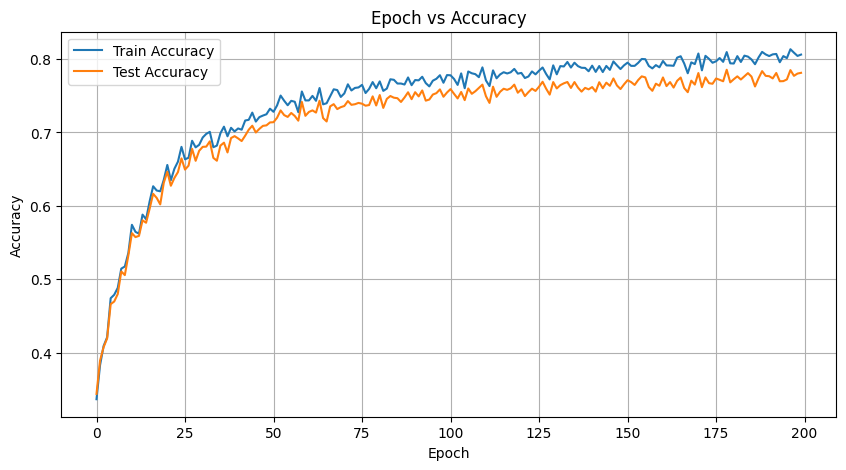

Average Wall-Clock Time per Epoch: 27.618 seconds


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(graph_epochs, graph_train_accs, label='Train Accuracy')
plt.plot(graph_epochs, graph_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()

average_epoch_time = sum(epoch_times) / len(epoch_times)
print(f"Average Wall-Clock Time per Epoch: {average_epoch_time:.3f} seconds")

## Adjoint = True, DOPRI5

In [ ]:
# model structure
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)


class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x

        out = self.relu(self.norm1(x))

        if self.downsample is not None:
            shortcut = self.downsample(out)

        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)

        return out + shortcut


class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)

class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        #self.dropout1 = nn.Dropout(0.1) # light dropout
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        #out = self.dropout1(out) # dropout
        out = self.conv1(t, out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(self.odefunc, x, self.integration_time, rtol=args.tol, atol=args.tol, method='dopri5')
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

In [ ]:
# model structure
def get_cifar_loaders(data_aug=True, batch_size=128, test_batch_size=1000, perc=1.0):
    if data_aug:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4), # 32 instead of 28 for larger images
            transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(30), # additional transforms
            transforms.ColorJitter(saturation=0.05, hue=0.05),
            transforms.ToTensor(),
            transforms.Normalize((0.4824, 0.4713, 0.4357), (0.1862, 0.1703, 0.1875))  # to normalize
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4824, 0.4713, 0.4357), (0.1862, 0.1703, 0.1875))  # to normalize
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4824, 0.4713, 0.4357), (0.1862, 0.1703, 0.1875))  # to normalize
    ])

    train_loader = DataLoader(
        datasets.CIFAR10(root='.data/cifar10', train=True, download=True, transform=transform_train), batch_size=batch_size,
        shuffle=True, num_workers=2, drop_last=True
    )

    train_eval_loader = DataLoader(
        datasets.CIFAR10(root='.data/cifar10', train=True, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10(root='.data/cifar10', train=False, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    return train_loader, test_loader, train_eval_loader


def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


def learning_rate_with_decay(batch_size, batch_denom, batches_per_epoch, boundary_epochs, decay_rates):
    initial_learning_rate = args.lr * batch_size / batch_denom

    boundaries = [int(batches_per_epoch * epoch) for epoch in boundary_epochs]
    vals = [initial_learning_rate * decay for decay in decay_rates]

    def learning_rate_fn(itr):
        lt = [itr < b for b in boundaries] + [True]
        i = np.argmax(lt)
        return vals[i]

    return learning_rate_fn


def one_hot(x, K):
    return np.array(x[:, None] == np.arange(K)[None, :], dtype=int)


def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        x = x.to(device)
        y = one_hot(np.array(y.numpy()), 10)

        target_class = np.argmax(y, axis=1)
        predicted_class = np.argmax(model(x).cpu().detach().numpy(), axis=1)
        total_correct += np.sum(predicted_class == target_class)
    return total_correct / len(dataset_loader.dataset)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


def get_logger(logpath, filepath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger(name='logger')
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
    # logger.info(filepath)
    # might not be necessary to read this file since it is raising errors anyway
    # with open(filepath, "r") as f:
        # logger.info(f.read())

    # for f in package_files:
        # logger.info(f)
        # with open(f, "r") as package_f:
            # logger.info(package_f.read())

    return logger

In [ ]:
# This is the main function used to run the entire colab notebook
if __name__ == '__main__':

    import datetime
    now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    makedirs(args.save)
    makedirs(args.save + '/' + now)

    logger = get_logger(logpath=os.path.join(args.save, now + '/logs'), filepath=os.path.abspath('')) # mod to adjust for ipynb
    logger.propagate = False
    logger.info(args)

    device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

# In order to plot the graphs, the data needs to be stored
    epochs = []
    train_accs = []
    test_accs = []
    epoch_times = []

    is_odenet = args.network == 'odenet'

    if args.downsampling_method == 'conv':
        downsampling_layers = [
            nn.Conv2d(3, 64, 3, 1, padding=1), # stride = 1
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        ]
    elif args.downsampling_method == 'res':
        downsampling_layers = [
            nn.Conv2d(3, 64, 3, 1),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ]

    feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
    fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]
    #fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), nn.Dropout(0.5), Flatten(), nn.Linear(64, 10)]


    model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

    logger.info(model)
    logger.info('Number of parameters: {}'.format(count_parameters(model)))

    criterion = nn.CrossEntropyLoss().to(device)
    train_loader, test_loader, train_eval_loader = get_cifar_loaders(
        args.data_aug, args.batch_size, args.test_batch_size
    )

    data_gen = inf_generator(train_loader)
    batches_per_epoch = len(train_loader)

    lr_fn = learning_rate_with_decay(
        args.batch_size, batch_denom=128, batches_per_epoch=batches_per_epoch, boundary_epochs=[60, 100, 140],
        decay_rates=[1, 0.1, 0.01, 0.001]
    )

    #optimizer = torch.optim.Adam(model.parameters(), lr=args.lr) # to try for Adam
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)

    best_acc = 0
    batch_time_meter = RunningAverageMeter()
    f_nfe_meter = RunningAverageMeter()
    b_nfe_meter = RunningAverageMeter()
    end = time.time()

    for epoch in range(args.nepochs):
        start_epoch_time = time.time()

        for itr in range(batches_per_epoch):
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_fn(itr)

            optimizer.zero_grad()
            x, y = data_gen.__next__()
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            if is_odenet:
                nfe_forward = feature_layers[0].nfe
                feature_layers[0].nfe = 0

            loss.backward()
            optimizer.step()

            if is_odenet:
                nfe_backward = feature_layers[0].nfe
                feature_layers[0].nfe = 0

            batch_time_meter.update(time.time() - end)
            if is_odenet:
                f_nfe_meter.update(nfe_forward)
                b_nfe_meter.update(nfe_backward)
            end = time.time()

        epoch_duration = time.time() - start_epoch_time
        epoch_times.append(epoch_duration)

        with torch.no_grad():
            train_acc = accuracy(model, train_eval_loader)
            val_acc = accuracy(model, test_loader)
            if val_acc > best_acc:
                torch.save({'state_dict': model.state_dict(), 'args': args}, os.path.join(args.save, now + '/model.pth'))
                best_acc = val_acc

        epochs.append(epoch)
        train_accs.append(train_acc)
        test_accs.append(val_acc)

        logger.info(
            f"Epoch {epoch:04d} | Time {epoch_duration:.3f} | Train Acc {train_acc:.4f} | Test Acc {val_acc:.4f} | NFE-F {f_nfe_meter.avg:.1f} | NFE-B {b_nfe_meter.avg:.1f}"
        )

Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Namespace(network='odenet', tol=0.001, adjoint=True, downsampling_method='res', nepochs=100, data_aug=True, lr=0.1, batch_size=128, test_batch_size=1000, save='./experiment1', debug=False, gpu=0)
Namespace(network='o

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Epoch 0000 | Time 39.324 | Train Acc 0.3855 | Test Acc 0.3882 | NFE-F 20.1 | NFE-B 20.3
Epoch 0000 | Time 39.324 | Train Acc 0.3855 | Test Acc 0.3882 | NFE-F 20.1 | NFE-B 20.3
Epoch 0000 | Time 39.324 | Train Acc 0.3855 | Test Acc 0.3882 | NFE-F 20.1 | NFE-B 20.3
Epoch 0000 | Time 39.324 | Train Acc 0.3855 | Test Acc 0.3882 | NFE-F 20.1 | NFE-B 20.3
Epoch 0000 | Time 39.324 | Train Acc 0.3855 | Test Acc 0.3882 | NFE-F 20.1 | NFE-B 20.3
Epoch 0000 | Time 39.324 | Train Acc 0.3855 | Test Acc 0.3882 | NFE-F 20.1 | NFE-B 20.3
Epoch 0001 | Time 38.789 | Train Acc 0.5381 | Test Acc 0.5310 | NFE-F 20.2 | NFE-B 20.0
Epoch 0001 | Time 38.789 | Train Acc 0.5381 | Test Acc 0.5310 | NFE-F 20.2 | NFE-B 20.0
Epoch 0001 | Time 38.789 | Train Acc 0.5381 | Test Acc 0.5310 | NFE-F 20.2 | NFE-B 20.0
Epoch 0001 | Time 38.789 | Train Acc 0.5381 | Test Acc 0.5310 | NFE-F 20.2 | NFE-B 20.0
Epoch 0001 | Time 38.789 | Train Acc 0.5381 | Test Acc 0.5310 | NFE-F 20.2 | NFE-B 20.0
Epoch 0001 | Time 38.789 | Train

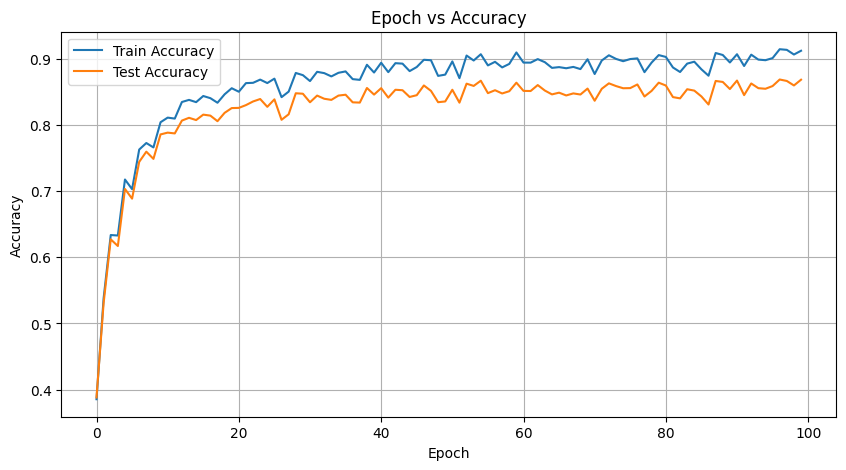

Average Wall-Clock Time per Epoch: 41.076 seconds


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.grid(True)
plt.show()

average_epoch_time = sum(epoch_times) / len(epoch_times)
print(f"Average Wall-Clock Time per Epoch: {average_epoch_time:.3f} seconds")